# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Откройте файл с данными и изучите общую информацию. 

In [6]:
import pandas as pd
import matplotlib.pyplot as plt 

In [2]:
df = pd.read_csv('real_estate_data.csv', sep='\t')

In [29]:
df.head(2)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07,3,2.7,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0


In [4]:
df.shape

(23699, 22)

array([[<AxesSubplot:title={'center':'total_images'}>,
        <AxesSubplot:title={'center':'last_price'}>,
        <AxesSubplot:title={'center':'total_area'}>,
        <AxesSubplot:title={'center':'rooms'}>],
       [<AxesSubplot:title={'center':'ceiling_height'}>,
        <AxesSubplot:title={'center':'floors_total'}>,
        <AxesSubplot:title={'center':'living_area'}>,
        <AxesSubplot:title={'center':'floor'}>],
       [<AxesSubplot:title={'center':'kitchen_area'}>,
        <AxesSubplot:title={'center':'balcony'}>,
        <AxesSubplot:title={'center':'airports_nearest'}>,
        <AxesSubplot:title={'center':'cityCenters_nearest'}>],
       [<AxesSubplot:title={'center':'parks_around3000'}>,
        <AxesSubplot:title={'center':'parks_nearest'}>,
        <AxesSubplot:title={'center':'ponds_around3000'}>,
        <AxesSubplot:title={'center':'ponds_nearest'}>],
       [<AxesSubplot:title={'center':'days_exposition'}>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>]], d

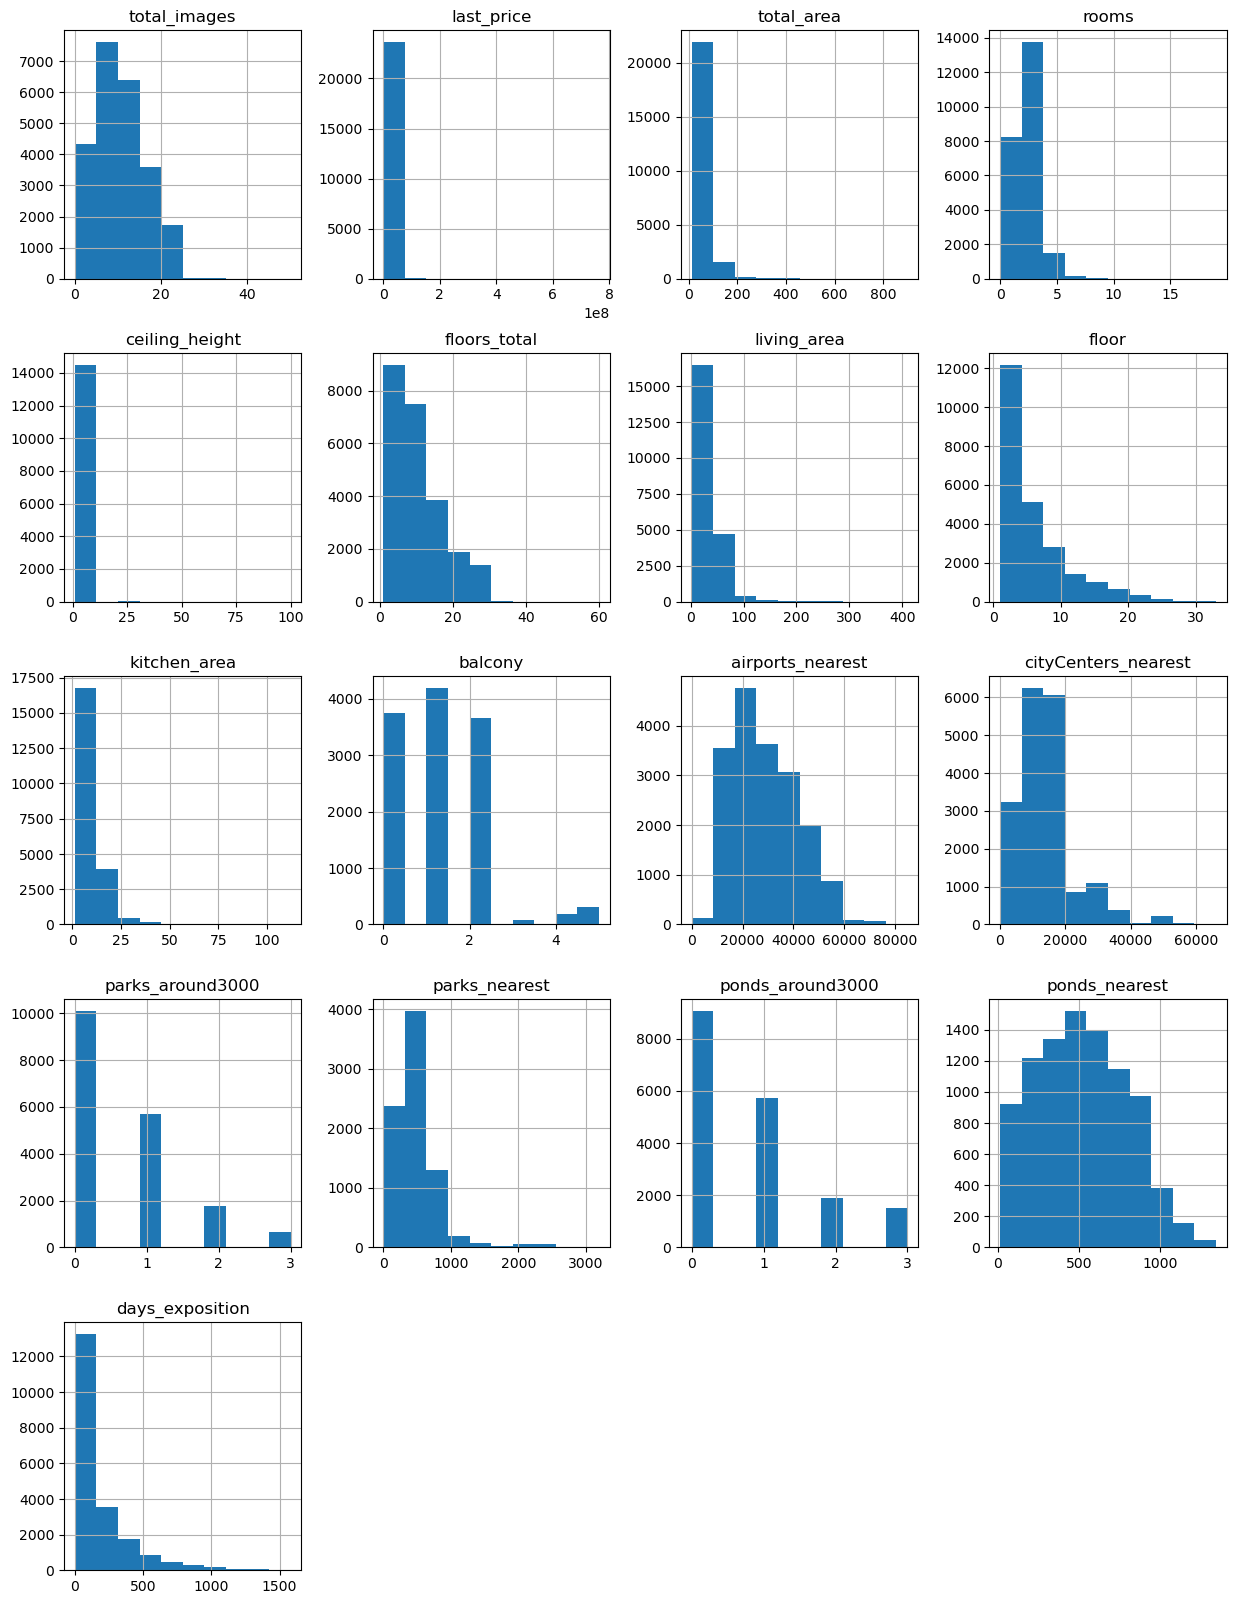

In [5]:
df.hist(figsize=(15, 20))

### Предобработка данных


#### Посмотрим какие поля сколько пропусков содержат:

<AxesSubplot: >

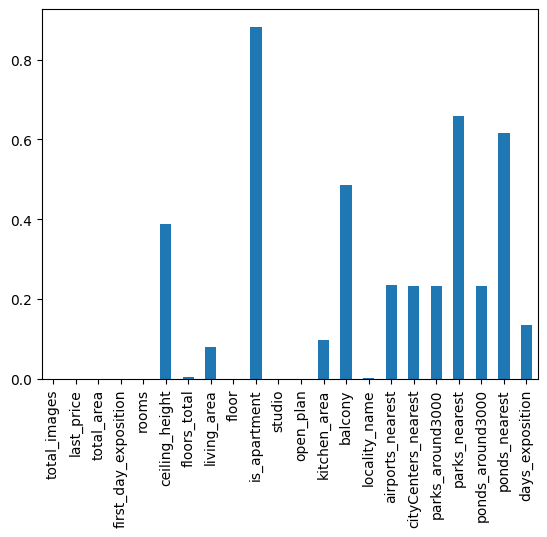

In [39]:
df.isna().mean().plot.bar()

Больше всего пропусков содержат слдеующие поля:<br>
<ul>
    <li></li>
    <li></li>
    <li></li>
</ul><br><br>
В случае с колличеством балконов, наличием в приделах 3000 м. парков и прудов, отсутствие данных можно приранять к отсутствию таких объектов, т.е. заменить пропущенные значения на ноль.


In [43]:
df['balcony'] = df['balcony'].fillna(0)
df['parks_around3000'] = df['parks_around3000'].fillna(0)
df['ponds_around3000'] = df['ponds_around3000'].fillna(0)

К пропускам данных могли привести следующие факторы:<bк>

#### Рассмотрим типы данных в столбцах

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23699 non-null  int64         
 1   last_price            23699 non-null  float64       
 2   total_area            23699 non-null  float64       
 3   first_day_exposition  23699 non-null  datetime64[ns]
 4   rooms                 23699 non-null  int64         
 5   ceiling_height        14504 non-null  float64       
 6   floors_total          23613 non-null  float64       
 7   living_area           21796 non-null  float64       
 8   floor                 23699 non-null  int64         
 9   is_apartment          2775 non-null   object        
 10  studio                23699 non-null  bool          
 11  open_plan             23699 non-null  bool          
 12  kitchen_area          21421 non-null  float64       
 13  balcony         

Большенство числовых значений представленны в формате float64. Даже если признак может быть выражен целым числов из-за наличия пропусков столбец будет преобразован в формат вещесвтвенных чисел, т.к. значение NaN к этому формату данных.<br><br>
Поле 'first_day_exposition' – содержит даты, но в формате object. Переведем значаения этого столбца в формат datetime (Timestamp), для удобной манируляции данными при работе.

In [15]:
df['first_day_exposition'] = pd.to_datetime(df['first_day_exposition'], format='%Y-%m-%dt%H:%M:%S')

In [42]:
type(df['first_day_exposition'][0])

pandas._libs.tslibs.timestamps.Timestamp

In [40]:
df.columns

Index(['total_images', 'last_price', 'total_area', 'first_day_exposition',
       'rooms', 'ceiling_height', 'floors_total', 'living_area', 'floor',
       'is_apartment', 'studio', 'open_plan', 'kitchen_area', 'balcony',
       'locality_name', 'airports_nearest', 'cityCenters_nearest',
       'parks_around3000', 'parks_nearest', 'ponds_around3000',
       'ponds_nearest', 'days_exposition'],
      dtype='object')

#### Изучите уникальные значения в столбце с названиями и устраните неявные дубликаты:

In [44]:
len(df['locality_name'].unique())

365

In [43]:
df['locality_name'].unique()

array(['Санкт-Петербург', 'посёлок Шушары', 'городской посёлок Янино-1',
       'посёлок Парголово', 'посёлок Мурино', 'Ломоносов', 'Сертолово',
       'Петергоф', 'Пушкин', 'деревня Кудрово', 'Коммунар', 'Колпино',
       'поселок городского типа Красный Бор', 'Гатчина', 'поселок Мурино',
       'деревня Фёдоровское', 'Выборг', 'Кронштадт', 'Кировск',
       'деревня Новое Девяткино', 'посёлок Металлострой',
       'посёлок городского типа Лебяжье',
       'посёлок городского типа Сиверский', 'поселок Молодцово',
       'поселок городского типа Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'посёлок Аннино',
       'поселок городского типа Ефимовский', 'посёлок Плодовое',
       'деревня Заклинье', 'поселок Торковичи', 'поселок Первомайское',
       'Красное Село', 'посёлок Понтонный', 'Сясьстрой', 'деревня Старая',
       'деревня Лесколово', '

In [45]:
df['locality_name'] = df['locality_name'].str.replace('ё', 'е')
df['locality_name'] = df['locality_name'].str.replace('городской поселок', 'поселок')
df['locality_name'] = df['locality_name'].str.replace('поселок городского типа', 'поселок')
df['locality_name'] = df['locality_name'].str.replace('село', '')
df['locality_name'] = df['locality_name'].str.replace('деревня', '')


In [46]:
len(df['locality_name'].unique())

322

#### Найдём и устраним редкие и выбивающиеся значения

In [19]:
df[df['rooms'] == df['rooms'].max()]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
14498,6,32250000.0,374.6,2018-06-09,19,NaN,5.0,264.5,2,NaN,...,27.6,NaN,Санкт-Петербург,19497.0,3574.0,0.0,NaN,2.0,548.0,114.0


In [35]:
df['ceiling_height'].max()

100.0

<AxesSubplot: >

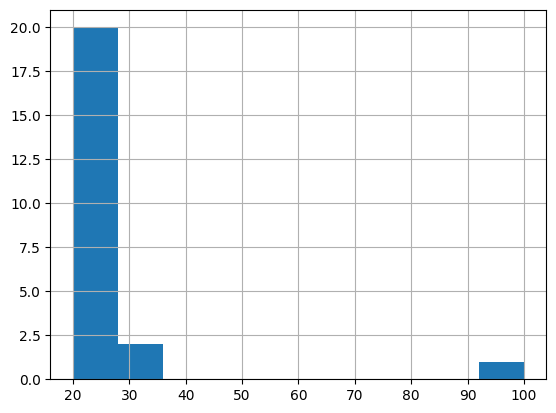

In [38]:
df['ceiling_height'].hist(range=(20, 100))

### Посчитайте и добавьте в таблицу новые столбцы

331

### Проведите исследовательский анализ данных

### Общий вывод

**Чек-лист готовности проекта**

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  открыт файл
- [ ]  файлы изучены (выведены первые строки, метод `info()`, гистограммы и т.д.)
- [ ]  определены пропущенные значения
- [ ]  заполнены пропущенные значения там, где это возможно
- [ ]  есть пояснение, какие пропущенные значения обнаружены
- [ ]  изменены типы данных
- [ ]  есть пояснение, в каких столбцах изменены типы и почему
- [ ]  устранены неявные дубликаты в названиях населённых пунктов
- [ ]  устранены редкие и выбивающиеся значения (аномалии) во всех столбцах
- [ ]  посчитано и добавлено в таблицу: цена одного квадратного метра
- [ ]  посчитано и добавлено в таблицу: день публикации объявления (0 - понедельник, 1 - вторник и т.д.)
- [ ]  посчитано и добавлено в таблицу: месяц публикации объявления
- [ ]  посчитано и добавлено в таблицу: год публикации объявления
- [ ]  посчитано и добавлено в таблицу: тип этажа квартиры (значения — «первый», «последний», «другой»)
- [ ]  посчитано и добавлено в таблицу: расстояние в км до центра города
- [ ]  изучены и описаны следующие параметры:
        - общая площадь;
        - жилая площадь;
        - площадь кухни;
        - цена объекта;
        - количество комнат;
        - высота потолков;
        - этаж квартиры;
        - тип этажа квартиры («первый», «последний», «другой»);
        - общее количество этажей в доме;
        - расстояние до центра города в метрах;
        - расстояние до ближайшего аэропорта;
        - расстояние до ближайшего парка;
        - день и месяц публикации объявления
- [ ]  построены гистограммы для каждого параметра
- [ ]  выполнено задание: "Изучите, как быстро продавались квартиры (столбец days_exposition). Этот параметр показывает, сколько дней «висело» каждое объявление.
    - Постройте гистограмму.
    - Посчитайте среднее и медиану.
    - В ячейке типа markdown опишите, сколько обычно занимает продажа. Какие продажи можно считать быстрыми, а какие — необычно долгими?"
- [ ]  выполнено задание: "Какие факторы больше всего влияют на общую (полную) стоимость объекта? Постройте графики, которые покажут зависимость цены от указанных ниже параметров. Для подготовки данных перед визуализацией вы можете использовать сводные таблицы."
        - общей площади;
        - жилой площади;
        - площади кухни;
        - количество комнат;
        - типа этажа, на котором расположена квартира (первый, последний, другой);
        - даты размещения (день недели, месяц, год);
- [ ]  выполнено задание: "Посчитайте среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений. Выделите населённые пункты с самой высокой и низкой стоимостью квадратного метра. Эти данные можно найти по имени в столбце `locality_name`."
- [ ]  выполнено задание: "Ранее вы посчитали расстояние до центра в километрах. Теперь выделите квартиры в Санкт-Петербурге с помощью столбца `locality_name` и вычислите среднюю цену каждого километра. Опишите, как стоимость объектов зависит от расстояния до центра города."
- [ ]  в каждом этапе есть промежуточные выводы
- [ ]  есть общий вывод